In [1]:
import torch
import torchvision
from torch import nn 
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
#%matplotlib inline
import numpy as np

# Import and split dataset

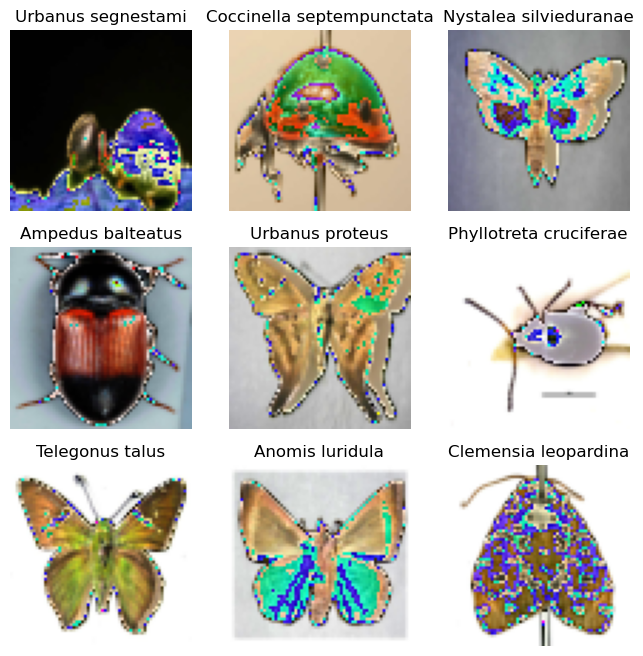

In [2]:
df = pd.read_csv('final_dataset.csv',index_col=0)
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(image_dataset), size=(1,)).item()
    img, label = image_dataset[sample_idx]
    img = transforms.functional.to_pil_image(img)
    figure.add_subplot(rows, cols, i)
    species_name = (list(image_dataset.class_to_idx.keys())[label]).replace('_',' ')
    plt.title(species_name)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [3]:
import random
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_1, X_test, y_train_1, y_test = dataset_utils.data_split(nucleotides,0.2,random_state=42)
print(y_test)
train_data = X_train_1
train_data['species_name'] = y_train_1

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False,random_state=42)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)
from torch.utils.data import Dataset, DataLoader
 
class WholeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.targets = data.targets#torch.tensor(targets)
        #self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index][0]
        y = self.targets[index]
        
        return x, y
    
    def __len__(self):
        return len(self.data)
        
whole_dataset = WholeDataset(image_dataset)
n_classes = np.unique(whole_dataset.targets).shape[0]
print(len(test_indices+val_indices+train_indices))
len(whole_dataset)

365    Bembidion normannum
292       Bledius gallicus
321       Praxis edwardsii
352        Andrena pilipes
18     Automeris managuana
              ...         
412         Hemiceras losa
413         Hemiceras losa
417     Hemiceras punctata
418         Hemiceras losa
421     Hemiceras punctata
Name: species_name, Length: 9991, dtype: object
32424


32424

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_size = 100 
batch_size =  64

In [21]:
train_imgs = torch.utils.data.Subset(whole_dataset, train_indices)
val_imgs = torch.utils.data.Subset(whole_dataset, val_indices)
test_imgs = torch.utils.data.Subset(whole_dataset, test_indices)
len(train_imgs)+len(val_imgs)+len(test_imgs)

32424

In [22]:
#SAMPLER TO BALANCE DATASET
T = [image_dataset.imgs[i][1] for i in train_indices]

unique_specie_labels,species_label_counts = np.unique(T,return_counts=True)
species2count = dict(zip(unique_specie_labels,species_label_counts))
for i in range(n_classes):
    if i not in species2count:
        species2count[i] = 0
species2prob = [1/species2count[i] if species2count[i]!=0 else 0 for i in range(n_classes)]
np.sum([species2prob[i]*species2count[i] for i in range(n_classes)])
balanced_sampler=torch.utils.data.WeightedRandomSampler(species2prob,len(train_imgs))

In [23]:
train_loader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size, num_workers=2,sampler = balanced_sampler)
val_loader = torch.utils.data.DataLoader(val_imgs, batch_size=batch_size,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_imgs, batch_size=4,shuffle=True, num_workers=2)
del test_loader
dataloaders = {"train":train_loader,"val":val_loader}
dataset_sizes = {'train': len(train_imgs.indices), 'val':len(val_imgs.indices)}

print(len(train_imgs.indices))
print(len(val_imgs.indices))
print(len(test_imgs.indices))


13039
6955
12430


In [24]:
print(y_test.shape)
print(y_train.shape)

(9991,)
(10840,)


In [25]:
# USED TO GENERATE ONLY FAKE IMAGES FROM DESCRIBED SPECIES
unique_training_labels = np.array([image_dataset.targets[i] for i in train_indices])
unique_training_labels = np.unique(unique_training_labels)

In [26]:
list(image_dataset.class_to_idx.keys())[45]

'Agrotis_ipsilon'

In [27]:
unique_training_labels

array([   0,    1,    2,    3,    4,    5,    6,    7,    9,   12,   13,
         15,   16,   18,   19,   21,   22,   23,   26,   29,   30,   32,
         33,   37,   39,   40,   42,   43,   45,   46,   47,   49,   50,
         51,   52,   53,   54,   56,   57,   60,   63,   64,   69,   70,
         73,   74,   75,   76,   77,   78,   79,   80,   82,   83,   84,
         85,   86,   88,   91,   95,   96,   97,   98,  100,  101,  102,
        103,  106,  108,  110,  111,  113,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  126,  127,  131,  132,  134,  135,  136,
        138,  139,  140,  141,  142,  143,  145,  147,  148,  149,  151,
        153,  154,  156,  158,  159,  160,  163,  164,  165,  167,  168,
        170,  171,  172,  173,  174,  177,  178,  180,  181,  182,  184,
        185,  191,  194,  195,  196,  199,  202,  203,  204,  205,  206,
        207,  208,  209,  210,  211,  212,  213,  214,  215,  216,  217,
        219,  220,  221,  222,  223,  224,  225,  2

# Initialize and train the models

In [28]:
import os 
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
fixed_latent = torch.randn(100, latent_size, 1, 1,device=device)
sample_random_classes = torch.tensor(np.random.randint(0, n_classes, fixed_latent.shape[0]),device=device)

In [29]:
import importlib
import modelC_Augment as m
importlib.reload(m)

discriminator = m.Discriminator()
discriminator.cuda()
generator = m.Generator(noise_size=100)
generator.cuda()
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),lr=2e-4,betas=(0.5, 0.999))
#discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(),lr=1e-5)
#generator_optimizer = torch.optim.RMSprop(generator.parameters(),lr=1e-5)
generator_optimizer = torch.optim.Adam(generator.parameters(),lr=2e-4,betas=(0.5, 0.999))


n_params = dataset_utils.count_trainable_parameters(discriminator);
print(n_params)
n_params = dataset_utils.count_trainable_parameters(generator);
print(n_params)


writer = SummaryWriter()

32233243
30220560


In [30]:
len(species2prob)

1050

In [31]:
from dataset_utils import Fit_params, Save_samples_params
with torch.no_grad():
    pass



fit_p = Fit_params(discriminator_optimizer,generator_optimizer,discriminator,generator,dataloaders,device,writer,batch_size,n_classes,latent_size,unique_training_labels)
save_p = Save_samples_params(fixed_latent,sample_random_classes,sample_dir)
losses_g, losses_d ,real_scores, fake_scores =m.fit(100,fit_p,save_p,species2prob,start_idx=1)

  0%|          | 0/204 [00:00<?, ?it/s]

/home/fogliodicarta/miniconda3/envs/insetti/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/100], loss_g: 1.9968, loss_d: 1.2899, real_score: 0.6571, fake_score: 0.5582
class accuracy real 0.140625
class accuracy fake 0.0
Saving generated-images-0001.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 1.2690, loss_d: 1.2064, real_score: 0.5745, fake_score: 0.4655
class accuracy real 0.140625
class accuracy fake 0.0
Saving generated-images-0002.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 1.1167, loss_d: 1.1450, real_score: 0.4974, fake_score: 0.4609
class accuracy real 0.234375
class accuracy fake 0.0
Saving generated-images-0003.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 1.4111, loss_d: 1.0383, real_score: 0.3930, fake_score: 0.3005
class accuracy real 0.296875
class accuracy fake 0.0
Saving generated-images-0004.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 1.3928, loss_d: 1.0831, real_score: 0.4358, fake_score: 0.3124
class accuracy real 0.1875
class accuracy fake 0.0
Saving generated-images-0005.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 0.8787, loss_d: 0.8800, real_score: 0.5041, fake_score: 0.3811
class accuracy real 0.296875
class accuracy fake 0.0
Saving generated-images-0006.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 1.2393, loss_d: 0.9378, real_score: 0.5128, fake_score: 0.3875
class accuracy real 0.28125
class accuracy fake 0.0
Saving generated-images-0007.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 1.0748, loss_d: 0.7021, real_score: 0.4674, fake_score: 0.2100
class accuracy real 0.34375
class accuracy fake 0.0
Saving generated-images-0008.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 1.7635, loss_d: 0.9277, real_score: 0.7211, fake_score: 0.6042
class accuracy real 0.390625
class accuracy fake 0.0
Saving generated-images-0009.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 2.2675, loss_d: 0.3649, real_score: 0.6743, fake_score: 0.3531
class accuracy real 0.4375
class accuracy fake 0.015625
Saving generated-images-0010.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 1.2470, loss_d: 0.3934, real_score: 0.6062, fake_score: 0.2970
class accuracy real 0.421875
class accuracy fake 0.015625
Saving generated-images-0011.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 1.9243, loss_d: 0.4449, real_score: 0.6672, fake_score: 0.3665
class accuracy real 0.390625
class accuracy fake 0.03125
Saving generated-images-0012.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 1.6702, loss_d: 0.4503, real_score: 0.7049, fake_score: 0.3974
class accuracy real 0.40625
class accuracy fake 0.0
Saving generated-images-0013.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 1.2868, loss_d: 0.4604, real_score: 0.5489, fake_score: 0.2202
class accuracy real 0.390625
class accuracy fake 0.015625
Saving generated-images-0014.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 1.6793, loss_d: 0.1112, real_score: 0.7617, fake_score: 0.2604
class accuracy real 0.390625
class accuracy fake 0.03125
Saving generated-images-0015.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.5400, loss_d: 0.6906, real_score: 0.7735, fake_score: 0.5344
class accuracy real 0.421875
class accuracy fake 0.0
Saving generated-images-0016.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 3.1915, loss_d: 0.3684, real_score: 0.8029, fake_score: 0.3891
class accuracy real 0.375
class accuracy fake 0.0
Saving generated-images-0017.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 2.2215, loss_d: -0.0515, real_score: 0.6269, fake_score: 0.1096
class accuracy real 0.578125
class accuracy fake 0.0
Saving generated-images-0018.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 2.1825, loss_d: -0.0610, real_score: 0.8178, fake_score: 0.2718
class accuracy real 0.5
class accuracy fake 0.0
Saving generated-images-0019.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 1.2038, loss_d: -0.1660, real_score: 0.8803, fake_score: 0.2295
class accuracy real 0.46875
class accuracy fake 0.0
Saving generated-images-0020.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 2.3501, loss_d: -0.1610, real_score: 0.8435, fake_score: 0.2362
class accuracy real 0.46875
class accuracy fake 0.03125
Saving generated-images-0021.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 2.8930, loss_d: 0.2459, real_score: 0.6558, fake_score: 0.3096
class accuracy real 0.53125
class accuracy fake 0.046875
Saving generated-images-0022.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 1.0577, loss_d: 0.4433, real_score: 0.4710, fake_score: 0.1252
class accuracy real 0.546875
class accuracy fake 0.0625
Saving generated-images-0023.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 1.9805, loss_d: -0.1261, real_score: 0.8373, fake_score: 0.1462
class accuracy real 0.40625
class accuracy fake 0.015625
Saving generated-images-0024.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 5.1519, loss_d: 0.3176, real_score: 0.8559, fake_score: 0.4347
class accuracy real 0.40625
class accuracy fake 0.03125
Saving generated-images-0025.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 4.1654, loss_d: -0.0638, real_score: 0.7190, fake_score: 0.1314
class accuracy real 0.515625
class accuracy fake 0.0
Saving generated-images-0026.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 2.3381, loss_d: -0.2737, real_score: 0.7769, fake_score: 0.1217
class accuracy real 0.578125
class accuracy fake 0.03125
Saving generated-images-0027.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 3.5732, loss_d: -0.0049, real_score: 0.7028, fake_score: 0.1811
class accuracy real 0.515625
class accuracy fake 0.0625
Saving generated-images-0028.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 1.6069, loss_d: -0.0817, real_score: 0.8151, fake_score: 0.2012
class accuracy real 0.46875
class accuracy fake 0.03125
Saving generated-images-0029.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.2882, loss_d: -0.1009, real_score: 0.7380, fake_score: 0.1128
class accuracy real 0.515625
class accuracy fake 0.046875
Saving generated-images-0030.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 2.9813, loss_d: -0.1618, real_score: 0.7731, fake_score: 0.1182
class accuracy real 0.484375
class accuracy fake 0.03125
Saving generated-images-0031.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 4.0316, loss_d: -0.3406, real_score: 0.7603, fake_score: 0.0251
class accuracy real 0.5625
class accuracy fake 0.015625
Saving generated-images-0032.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 3.4099, loss_d: -0.3632, real_score: 0.8474, fake_score: 0.1308
class accuracy real 0.546875
class accuracy fake 0.046875
Saving generated-images-0033.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 6.9574, loss_d: -0.4409, real_score: 0.9093, fake_score: 0.1820
class accuracy real 0.578125
class accuracy fake 0.0625
Saving generated-images-0034.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 1.9434, loss_d: -0.2383, real_score: 0.7280, fake_score: 0.0769
class accuracy real 0.53125
class accuracy fake 0.03125
Saving generated-images-0035.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 3.6764, loss_d: -0.3991, real_score: 0.7945, fake_score: 0.0731
class accuracy real 0.59375
class accuracy fake 0.015625
Saving generated-images-0036.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 3.6204, loss_d: -0.5915, real_score: 0.9265, fake_score: 0.0626
class accuracy real 0.5625
class accuracy fake 0.015625
Saving generated-images-0037.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 4.7845, loss_d: -0.5773, real_score: 0.8581, fake_score: 0.0398
class accuracy real 0.5625
class accuracy fake 0.0625
Saving generated-images-0038.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 2.8625, loss_d: -0.7729, real_score: 0.9395, fake_score: 0.0749
class accuracy real 0.640625
class accuracy fake 0.0625
Saving generated-images-0039.png


  0%|          | 0/204 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 5.3682, loss_d: -0.5444, real_score: 0.9092, fake_score: 0.0471
class accuracy real 0.5
class accuracy fake 0.03125
Saving generated-images-0040.png


  0%|          | 0/204 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:

dataset_utils.species_label_to_genus_label()

# Altra roba

In [33]:
raise Exception
torch.save({
            'epoch':40,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': generator_optimizer.state_dict(),
            }, "checkpoints/generatorC_augmented_rare")
torch.save({
            'epoch': 40,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': discriminator_optimizer.state_dict(),
            }, "checkpoints/discriminatorC_augmented_rare")

In [ ]:
image_dataset.class_to_idx['Hemiceras_nigrescens']

In [ ]:
image_dataset.class_to_idx['Abax_parallelepipedus']

In [ ]:
raise Exception
fixed_latent2 = torch.randn(1, latent_size, 1, 1,device=device)

for class_fix in range(len(image_dataset.class_to_idx)):
    random_classes = torch.tensor(np.random.randint(class_fix, class_fix+1, fixed_latent2.shape[0]),device=device)
    print(random_classes)
    specie_name = list(image_dataset.class_to_idx.keys())[class_fix]
    specie_name_no_underscore= specie_name.replace("_"," ")
    if specie_name_no_underscore in list(X_train['species_name']):
        fake_images = generator(fixed_latent2,random_classes)
        fake_fname = f'{specie_name}.png'
        save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
        #writer.add_image('sample image',denorm(fake_images[0]),global_step=index)
        print('Saving', fake_fname)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    

In [ ]:
'Nola cucllatella' in list(X_train['species_name'])

In [ ]:
X_train['species_name']

In [ ]:

ct = nn.ConvTranspose2d( 100+embedding_size, 64 * 8, 4, 1, 0, bias=False)

In [ ]:
i = torch.ones(32,1100,1,1)

In [ ]:
x = ct(i)
print(x.shape)
up = nn.Upsample(scale_factor=2, mode='bilinear')
x = up(x)
print(x.shape)
conv1 = nn.Conv2d(64*8,64*8,1)
x = conv1(x)
print(x.shape)
x = up(x)
print(x.shape)
conv2 = nn.Conv2d(64*8,64*4,1)
x = conv2(x)
print(x.shape)
x = up(x)
print(x.shape)
conv3 = nn.Conv2d(64*4,64*2,1)
x = conv3(x)
print(x.shape)
x = up(x)
print(x.shape)
conv4 = nn.Conv2d(64*2,64*1,1)
x = conv4(x)
print(x.shape)
x = up(x)
print(x.shape)
conv5 = nn.Conv2d(64*1,3,1)
x = conv5(x)
print(x.shape)
x = up(x)
print(x.shape)

In [ ]:
a = torch.eye(2,3)
a[0][0]=2
a[0][1]=3
a

In [ ]:
a.mean(1)

In [ ]:
a.shape